In [46]:
# Skip cell (weird vscode bug)

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from objectives import *
import copy
from pebsi.processing.plotting_fxns import *
import pebsi.processing.gridsearch_processing as gsproc
import pebsi.processing.gridsearch_plotting as gsplot

In [1]:
# ds = xr.open_dataset(gsproc.base_fp + '07_30_D_2/grid_07_30_set5_run0_0.nc')
# print(ds.attrs['c5'], ds.attrs['kp'])
# plot_seasonal_mass_balance(ds)
# for fn in [gsproc.base_fp + f'07_30_D_2/grid_07_30_set{i}_run0_0.nc' for i in range(9)]:
#     ds = xr.open_dataset(fn)
#     kp = ds.attrs['kp']
#     c5 = ds.attrs['c5']
#     ds_old = gsproc.get_any(result_dict,c5,kp,'D')
#     print(fn.replace('_0.nc','_broken.nc'))
#     ds_old.to_netcdf(fn.replace('_0.nc','_broken.nc'))
#     ds_old.close()
#     ds.to_netcdf(gsproc.get_any(result_dict, c5, kp, 'D',out='fn'))
#     ds.close()

In [11]:
for c5 in ['0.01','0.012','0.024','0.016','0.018']:
    ds = gsproc.get_any(result_dict,c5,'3','D')
    print(seasonal_mass_balance(ds)[1])

0.5649046660512499
0.492723427902011
0.54739308000921
0.5409965607437032
0.5760828278196217


In [24]:
# ===== GET RESULTS DICT =====
# gsproc.process_runs('long', sites='all')                  # This function re-creates each individual run .pkl and thus takes ~60 minutes in series
result_dict = gsproc.get_result_dict(force_redo='long')                      # Add force_redo=True to recompile the result dictionaries

In [25]:
# ===== NORMALIZE =====
lim_percentile = 75
all_error = ['2024','snowdensity','winter','summer','snowdepth','annual']
error_lims = {}
for err in all_error:
    error_lims[err] = gsproc.get_percentile(result_dict, err, lim_percentile)
result_dict = gsproc.add_normalized(result_dict, error_lims=error_lims)

KeyError: '2024_MAE'

In [26]:
# ===== DEFINE LIST OF ERRORS TO PERFORM CALIBRATION =====
error_list = ['summer','winter','snowdensity','snowdepth']

{'c5': ['0.01', '0.012', '0.014', '0.016', '0.018', '0.02', '0.022', '0.024'], 'kp': ['0.25', '0.5', '0.75', '1', '1.25', '1.5', '1.75', '2', '2.25', '2.5', '2.75', '3']}


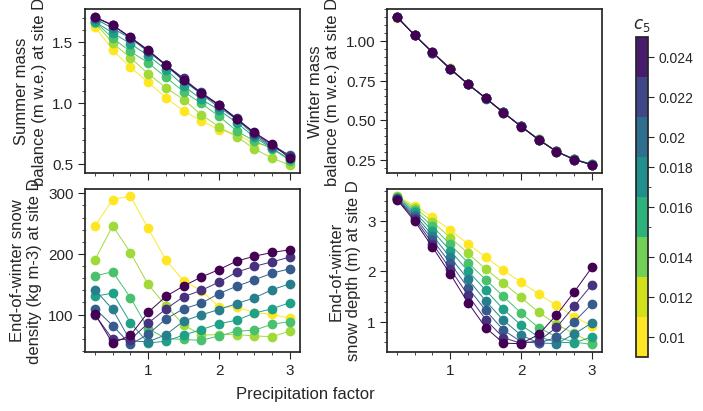

{'c5': ['0.01', '0.012', '0.014', '0.016', '0.018', '0.02', '0.022', '0.024'], 'kp': ['0.25', '0.5', '0.75', '1', '1.25', '1.5', '1.75', '2', '2.25', '2.5', '2.75', '3']}


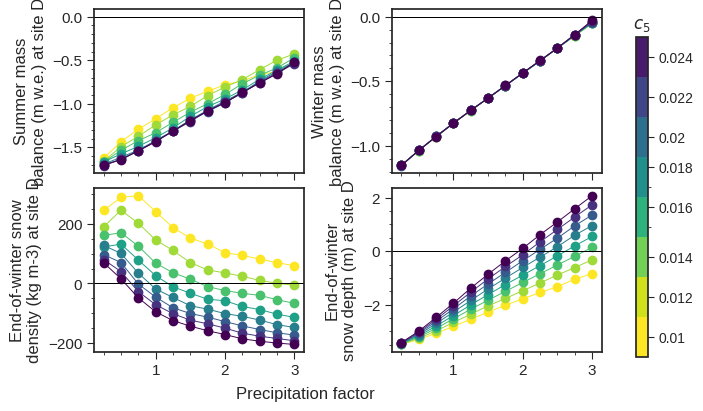

In [28]:
# ===== MULTI-PANEL TRADEOFFS =====
gsplot.plot_tradeoffs(result_dict,error_list,savefig=True,site='D')
gsplot.plot_tradeoffs(result_dict,error_list,metric='ME',savefig=True,site='D')

In [9]:
# ===== FIND PARETO FRONTS AND PLOT AN EXAMPLE =====
fp_pickle = 'pebsi/processing/pareto_results_7_26.pkl'
if not os.path.exists(fp_pickle):
    all_bootstrap_pareto, all_calib, all_valid, optima = gsproc.get_pareto_fronts_bootstrap(1000, result_dict, error_list, return_validation=True, return_optima=True)
    all_pareto_flat = list(set(list(itertools.chain(*all_bootstrap_pareto))))
    pareto_results = {'all_pareto_flat':all_pareto_flat,
                        'all_pareto':all_bootstrap_pareto,
                        'all_calib':all_calib,
                        'all_valid':all_valid,
                        'optima':optima}
    # pickle dict
    with open(fp_pickle,'wb') as f:
        pickle.dump(pareto_results, f)
else:
    # open pickle dict
    with open(fp_pickle,'rb') as f:
        pareto_results = pickle.load(f)
        all_pareto_flat = pareto_results['all_pareto_flat']
        all_bootstrap_pareto = pareto_results['all_pareto']
        all_calib = pareto_results['all_calib']
        all_valid = pareto_results['all_valid']
        optima = pareto_results['optima']
        f.close()

# gsplot.plot_pareto_fronts(error_list, result_dict, split=1)

In [10]:
fp_pickle_seasonal = 'pebsi/processing/pareto_results_7_26_seasonal.pkl'
if not os.path.exists(fp_pickle_seasonal):
    all_bootstrap_pareto_seasonal = gsproc.get_pareto_fronts_bootstrap(1000, result_dict, ['summer','winter'])
    frequency_dict_seasonal, _ = gsproc.get_frequency(all_bootstrap_pareto_seasonal)

    all_bootstrap_pareto_annual = gsproc.get_pareto_fronts_bootstrap(1000, result_dict, ['annual'])
    frequency_dict_annual, _ = gsproc.get_frequency(all_bootstrap_pareto_annual)

    pareto_results = {'all_pareto_seasonal':all_bootstrap_pareto_seasonal,
                            'frequency_seasonal':frequency_dict_seasonal,
                            'all_pareto_annual':all_bootstrap_pareto_annual,
                            'frequency_annual':frequency_dict_annual}

    # pickle dict
    with open(fp_pickle_seasonal,'wb') as f:
        pickle.dump(pareto_results, f)
else:
    # open dict
    with open(fp_pickle_seasonal,'rb') as f:
        pareto_results = pickle.load(f)
        all_bootstrap_pareto_seasonal = pareto_results['all_pareto_seasonal']
        frequency_dict_seasonal = pareto_results['frequency_seasonal']
        all_bootstrap_pareto_annual = pareto_results['all_pareto_annual']
        frequency_dict_annual = pareto_results['frequency_annual']
        f.close()

In [11]:
# ===== WEIGHT AND FIND THE BEST =====
best_by = gsproc.get_best_normalized(error_list, result_dict, prints=True, site='mean')
best = best_by[-1]

Weights:
    summer     winter snowdensity  snowdepth     best
         1          0          0          0      ('0.024', '1')
         0          1          0          0      ('0.015', '2.375')
         0          0          1          0      ('0.017', '1')
         0          0          0          1      ('0.01', '3')
      0.25       0.25       0.25       0.25      ('0.016', '2.25')


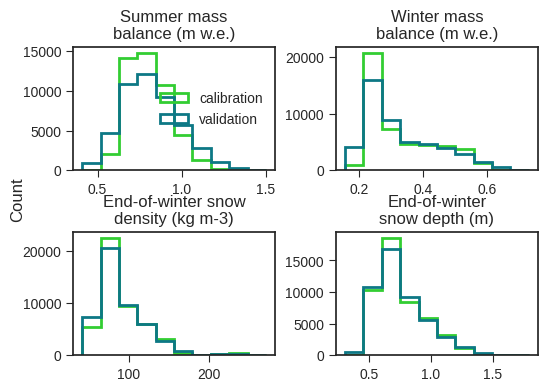

In [12]:
# ===== COMPARE VALIDATION TO CALIBRATION =====
gsplot.compare_calib_valid(error_list, all_calib, all_valid, savefig=True)

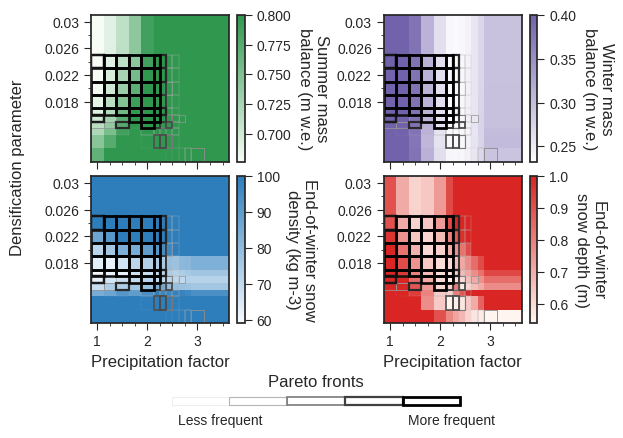

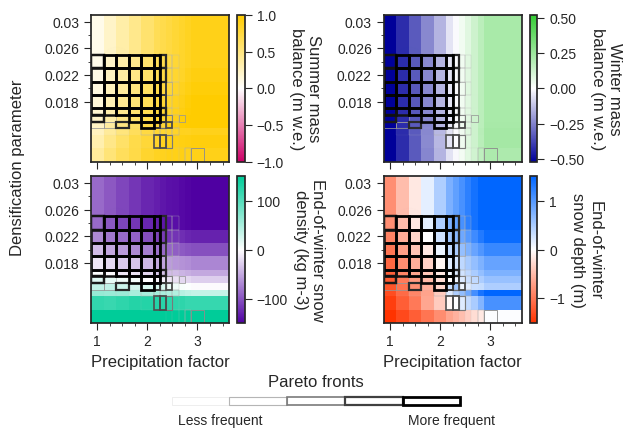

In [13]:
frequency_dict, _ = gsproc.get_frequency(all_bootstrap_pareto)
gsplot.plot_pareto_heatmap(frequency_dict, result_dict, error_list, savefig=True, metric='MAE', optima=optima)
gsplot.plot_pareto_heatmap(frequency_dict, result_dict, error_list, savefig=True, metric='ME', optima=optima)

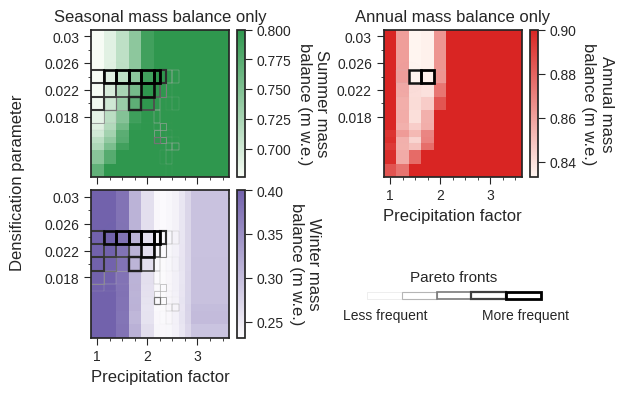

In [14]:
# 2x2 PLOT
fig = plt.figure(figsize=(6,4))
gs = mpl.gridspec.GridSpec(4,2, figure=fig, wspace=0.7, hspace=0.2)

# Generate subplots for seasonal 
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[2:4, 0])
ax_left = [ax1,ax2]
# Plot heatmap
fig, ax_left = gsplot.plot_pareto_heatmap(frequency_dict_seasonal, result_dict, ['summer','winter'], savefig=False, metric='MAE', figaxes = (fig, ax_left), legend=False)
# Labeling
ax_left[0].set_xticklabels(['','',''])
ax_left[0].set_title('Seasonal mass balance only', fontsize=12)
ax_left[1].set_title('')
ax_left[1].set_xlabel('Precipitation factor', fontsize=12)

# Generate subplot for annual
ax_right = fig.add_subplot(gs[0:2, 1])
# Plot heatmap
fig, ax_right = gsplot.plot_pareto_heatmap(frequency_dict_annual, result_dict, ['annual'], savefig=False, metric='MAE', figaxes = (fig, [ax_right]), legend=False)
# Labeling
ax_right[0].set_title('Annual mass balance only', fontsize=12)
ax_right[0].set_xlabel('Precipitation factor', fontsize=12)

cax = fig.add_axes([0.58,0.2,0.3,0.03])
cmap = mpl.colormaps['Grays']
norm =  mpl.colors.Normalize(vmin=0,vmax=5)
boundaries = [1,2,3,4,5]
for b in boundaries:
    alpha = 1 - (5 - b)/5
    rect = mpl.patches.Rectangle((b, 0), 1, 1, linewidth=alpha*2, edgecolor=cmap(norm(b)), facecolor='none')
    cax.add_patch(rect)
border = 0.1
cax.set_xlim(np.min(boundaries) - border, np.max(boundaries) + 1 + border)
cax.set_ylim(-0.3,1.3)
cax.axis('off')
cax.text(0.3, -2.7, 'Less frequent')
cax.text(4.3, -2.7, 'More frequent')
cax.set_title('Pareto fronts',fontsize=11)
fig.supxlabel('')

plt.savefig('/trace/group/rounce/cvwilson/Output/seasonal_annual_only_calibration.png', dpi=250, bbox_inches='tight')

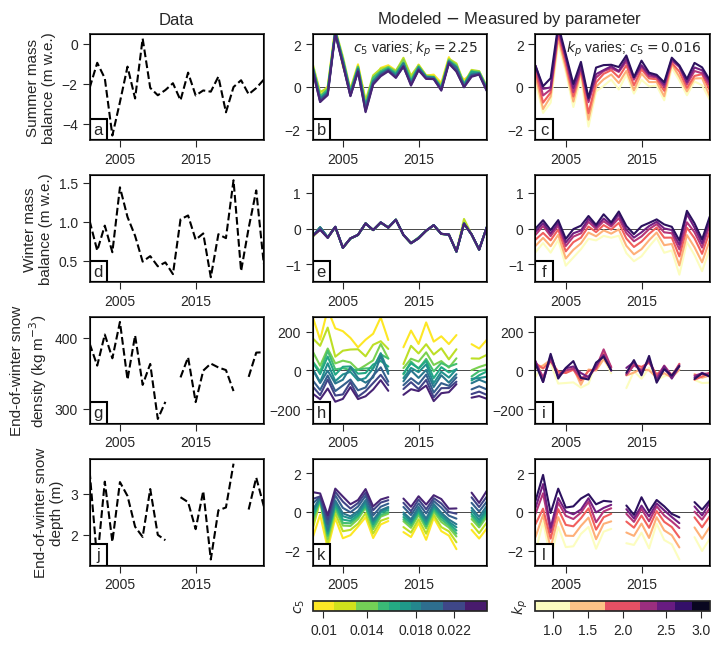

In [15]:
# ===== TRADEOFFS TIMESERIES=====
gsplot.plot_difference_by_param(best, result_dict, plot_vars=error_list, savefig=True)

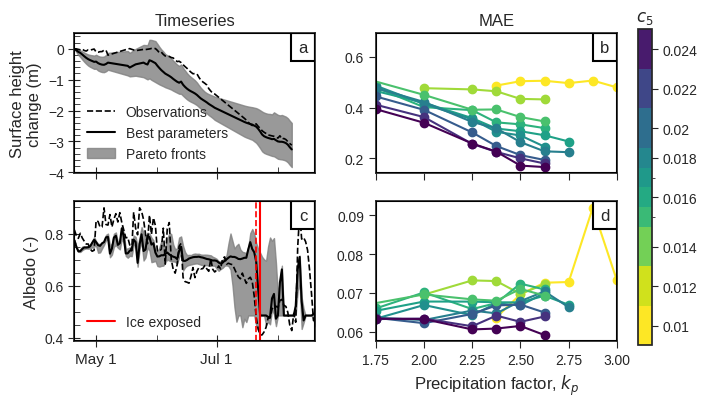

In [16]:
# ===== PLOT 2024 PARETO FRONT VALIDATION =====
gsplot.plot_pareto_2024(all_pareto_flat, result_dict, frequency_dict, best, savefig=True)

In [17]:
# ===== TRADEOFFS TIMESERIES FOR ONE RUN TYPE =====
# gsplot.plot_tradeoffs_2024(result_dict, best_by[-1])
# gsplot.plot_tradeoffs_annual(result_dict, best_by[-1])
# gsplot.plot_tradeoffs_snowpits(result_dict, best_by[-1])

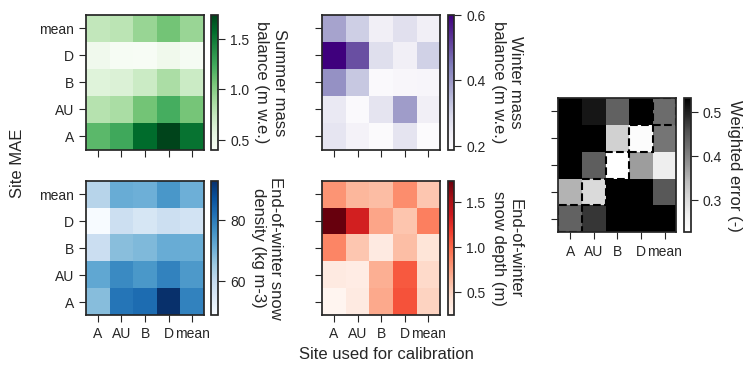

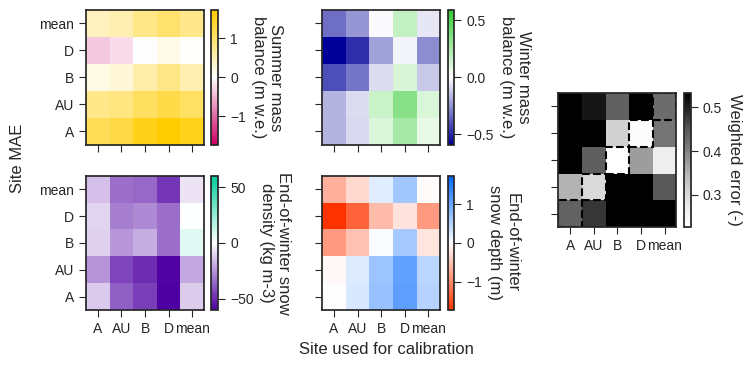

In [18]:
# ===== CALIBRATE ON ONE SITE =====
# gsplot.plot_heatmap_by_site(error_list, result_dict)
# gsplot.plot_best_by_site(error_list, result_dict)
error_list_heatmap = error_list + ['weighted']
gsplot.plot_heatmap_by_site_weighted(error_list_heatmap, result_dict, metric='MAE', savefig=True)
gsplot.plot_heatmap_by_site_weighted(error_list_heatmap, result_dict, metric='ME', savefig=True)

In [ ]:
# ===== PLOT A SINGLE RUN =====
# gsplot.plot_best_seasonal(best, result_dict, savefig=True)
# gsplot.plot_best_2024(best, result_dict, savefig=True)
# gsplot.plot_best_snowpits(best_by[-1], result_dict, savefig=True)
# gsplot.plot_best_snowmass(best_by[-1], result_dict) 
# gsplot.plot_best_albedo(best, result_dict, savefig=True)

AU -3.09
AB -2.96
B -1.79
D -1.19
T -1.0299999999999998


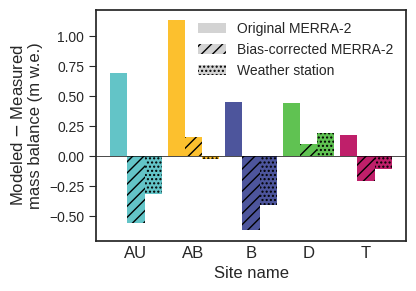

In [11]:
with open('/trace/group/rounce/cvwilson/Output/bias_correct/bias_correction_test.pkl', 'rb') as f:
    mb_dict = pickle.load(f)
gsplot.plot_bias_correction(mb_dict, True)

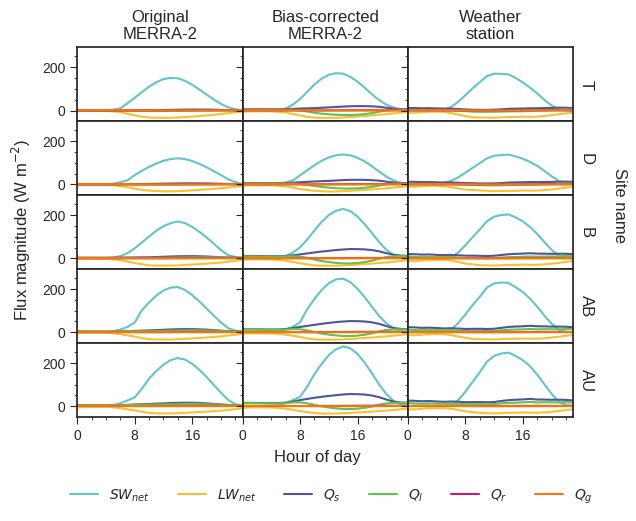

In [9]:
gsplot.plot_fluxes(savefig=True)

0.0011806776822974462


np.float64(0.001293037376728132)

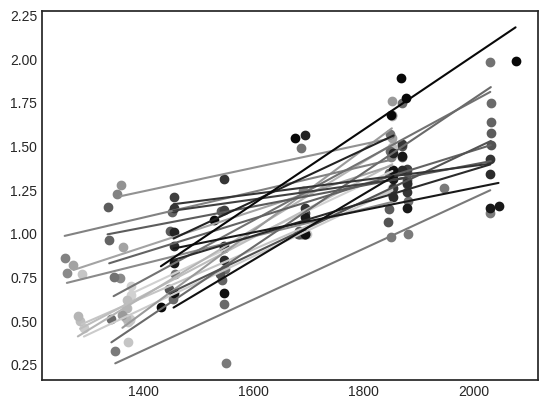

In [19]:
gsplot.find_precip_gradient()

In [19]:
sens_dict = {}
fp = '/trace/group/rounce/cvwilson/Output/sensitivity/'
def get_mb(fn):
    ds = xr.open_dataset(fn)
    summer_mb = ds.accum + ds.refreeze - ds.melt
    ds.close()
    return summer_mb.sum().values
def get_dens(fn):
    ds = xr.open_dataset(fn)
    all = []
    for t in ds.time.values:
        density = ds.sel(time=t).layerdensity.values
        height = ds.sel(time=t).layerheight.values
        where = np.where(density < 899)[0]
        avg = np.sum(density[where]*height[where] / np.sum(height[where]))
        all.append(avg)
    avg = np.mean(all)
    ds.close()
    return avg
sens_dict['base'] = {}
sens_dict['base']['base'] = {}
sens_dict['base']['base']['mb'] = get_mb(fp + 'base_0.nc')
sens_dict['base']['base']['density'] = get_dens(fp + 'base_0.nc')

for var in ['kp','Boone-c5','lapserate','roughness-fresh-snow','roughness-aged-snow','roughness-ice','albedo-ground','ksp-BC','ksp-OC','ksp-dust']:
    sens_dict[var.replace('-','_')] = {}
    for direction in ['+20','-20']:
        sens_dict[var.replace('-','_')][direction] = {}
        sens_dict[var.replace('-','_')][direction]['mb'] = get_mb(f'{fp}{var}_{direction}_0.nc') 
        sens_dict[var.replace('-','_')][direction]['density'] = get_dens(f'{fp}{var}_{direction}_0.nc') 


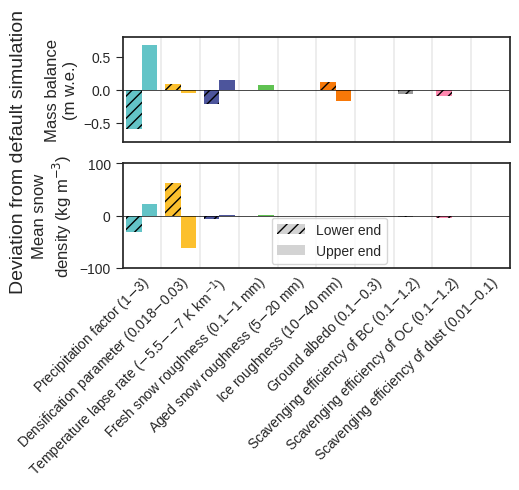

In [24]:
# with open('/trace/group/rounce/cvwilson/Output/sensitivity/sensitivity_test.pkl','wb') as f:
#     # sens_dict = pickle.load(f)
#     pickle.dump(sens_dict, f)
gsplot.plot_sensitivity(sens_dict, savefig=True)

In [ ]:
# ripe_dict = {'AU': {10: pd.Timestamp('2024-04-21 22:45:00'), 40: pd.Timestamp('2024-04-26 05:30:00'), 80: pd.Timestamp('2024-05-01 14:30:00'), 150: pd.Timestamp('2024-04-27 14:30:00')}, 'B': {10: pd.Timestamp('2024-04-21 21:15:00'), 70: pd.Timestamp('2024-05-18 20:15:00'), 135: pd.Timestamp('2024-05-27 08:45:00'), 200: pd.Timestamp('2024-05-27 11:30:00'), 270: pd.Timestamp('2024-05-26 18:30:00')}, 'D': {10: pd.Timestamp('2024-06-01 18:00:00'), 40: pd.Timestamp('2024-06-02 14:15:00'), 80: pd.Timestamp('2024-06-02 16:45:00'), 120: pd.Timestamp('2024-06-05 14:00:00'), 150: pd.Timestamp('2024-06-05 08:45:00')}}
# site = 'B'
# ripe_dates = {}
# # if site == 'AU':
# #     ds,s,e = getds(f'~/research/Output/EB/Gulkana_2025_01_29_0.nc')
# # else:
# #     ds,s,e = getds(f'~/research/Output/EB/Gulkana_01_29_2024{site}_0.nc')
# ds = gsproc.get_any(result_dict, '0.022','2.5',site,'2024')
# fig, axes = plt.subplots(2,1,figsize=(5,3),sharex=True)
# (ax1,ax2) = axes

# if site =='D':
#     axes[0] = visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layertemp'], plot_ax=[axes[0]])[0] #,plot_firn=False)
# else:
#     axes[0] = visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layertemp'],plot_ax=[axes[0]])[0]
# # Scatter initial heights of iButtons
# depths = np.array([f for f in ripe_dict[site]])
# heights = depths[-1] - depths
# start = np.array([pd.to_datetime('2024-04-22') for _ in range(len(heights))])
# ms=100
# if site == 'D':
#     heights += 700
# for c in range(len(heights)):
#     ax1.scatter(start[c],heights[c]/100,marker='>',color=colors[c],s=ms,edgecolor='k',linewidth=0.5,)
# ax1.scatter(np.nan,np.nan,color='gray',marker='>',label='iButtons buried',s=ms,edgecolor='k',linewidth=0.5,)

# # Scatter ripened dates for each sensor
# colors = ['#63c4c7','#fcc02e','#4D559C','#60C252','#BF1F6A']
# for c,depth in enumerate(ripe_dict[site]):
#     if site != 'B':
#         height = 150 - depth
#     else:
#         height = 270 - depth
#     if site == 'D':
#         height += 700
#     ax1.scatter(ripe_dict[site][depth],height/100,marker='^',s=ms,color=colors[c],edgecolor='k',linewidth=0.5,)
# ax1.scatter(np.nan,np.nan,marker='^',color='gray',s=ms,edgecolor='k',linewidth=0.5,label='iButtons ripe')
# ax1.set_ylabel('Height above\nice (m)',fontsize=12)
# ax1.legend()

# # Add lineplot of temperatures
# df = pd.read_csv('/trace/home/cvwilson/research/Data/iButtons_2024_B.csv',index_col=0)
# df.index = pd.to_datetime(df.index)
# df = df.resample('h').mean()
# for c,col in enumerate(df.columns):
#     values = df.loc[:list(ripe_dict[site].values())[c]]
#     ax2.plot(values.index, values[col].values,color=colors[c],label=list(ripe_dict[site])[c])
# leg = ax2.legend(title='Initial depth (cm)',loc='center',bbox_to_anchor=(1.2,0.4))
# leg.get_title().set_color('black')
# ax2.axhline(0,color='0.2',linewidth=0.8)
# ax2.tick_params(length=5)
# ax2.set_xticks(pd.date_range('2024-05-01','2024-08-01',freq='MS'))
# ax2.set_ylabel('Measured\ntemperature ($^{\circ}$C)',fontsize=12)

# pos1 = ax1.get_position()
# ax2.set_position([pos1.x0, ax2.get_position().y0, pos1.width, ax2.get_position().height])

# plt.savefig(gsproc.base_fp+'snow_temperature.png',dpi=200,bbox_inches='tight')
# plt.show()

In [21]:
all_r2 = []
params = best
for site in gsproc.sitedict['2024'][1:]: #['ABB','B','BD','T']: # 
    site_all = []
    for params in all_pareto_flat:
        dh_mod = result_dict[params[0]][params[1]][site]['dh_mod']
        dh_meas = result_dict[params[0]][params[1]][site]['dh_meas']
        ss_tot = np.sum((dh_meas - np.mean(dh_meas)) ** 2)
        ss_res = np.sum((dh_meas - dh_mod) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        site_all.append(r_squared)
    print(site, np.mean(site_all), np.min(site_all), np.max(site_all))
    all_r2.append(site_all)
print(np.mean(all_r2), np.min(all_r2), np.max(all_r2))

ABB 0.873365263300831 0.7001472154963605 0.9515498789210524
B 0.7488043421944476 0.44550388652161554 0.9230513421430637
BD 0.9097373919129427 0.7783009179773077 0.983845428490239
D 0.6434491143117178 -0.2762013818967184 0.9953339625856638
T 0.34616848480114343 -0.6301759241952689 0.741430575062964
0.7043049193042163 -0.6301759241952689 0.9953339625856638


In [19]:
all_r2 = []
params = best
for site in gsproc.sitedict['2024'][1:]: #['ABB','B','BD','T']: # 
    
    dh_mod = result_dict[params[0]][params[1]][site]['dh_mod']
    dh_meas = result_dict[params[0]][params[1]][site]['dh_meas']
    ss_tot = np.sum((dh_meas - np.mean(dh_meas)) ** 2)
    ss_res = np.sum((dh_meas - dh_mod) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    all_r2.append(r_squared)
    print(site, r_squared)
print(np.mean(all_r2), np.min(all_r2), np.max(all_r2))

ABB 0.8813751966577936
B 0.7812851328232331
BD 0.9411347811025873
D 0.8378349163006593
T 0.5041172671699352
0.7891494588108416 0.5041172671699352 0.9411347811025873


In [41]:
-2.96 - -2.808554890350936

-0.15144510964906388

In [46]:
f= []
for (c5,kp) in all_pareto_flat:
    f.append(result_dict[c5][kp]['B']['summer_MAE'])
print(np.mean(f))

0.5868873442250742


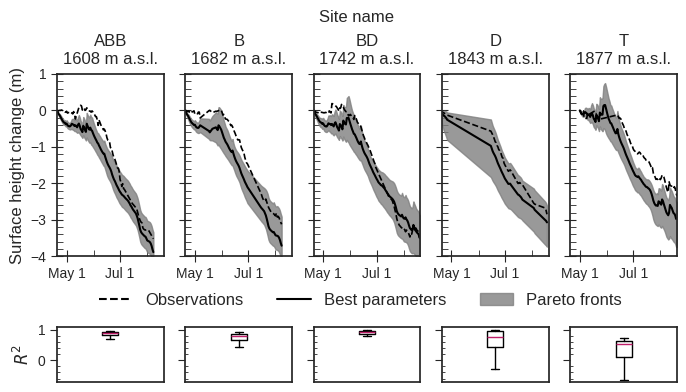

In [53]:
# gsplot.plot_best_2024_dh(best, result_dict)
gsplot.plot_pareto_2024_dh(result_dict, all_pareto_flat, best,savefig=True)

['sans-serif']


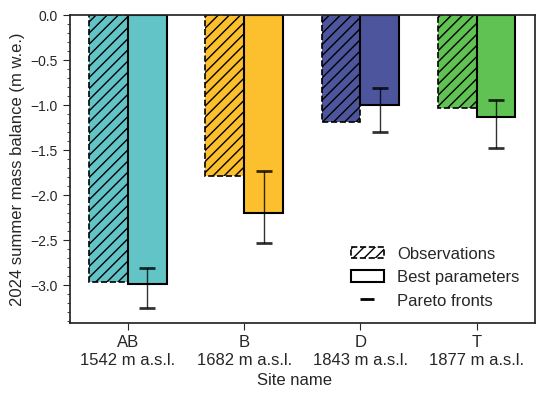

In [106]:
gsplot.plot_pareto_2024_mb(result_dict, all_pareto_flat, best, savefig=True)

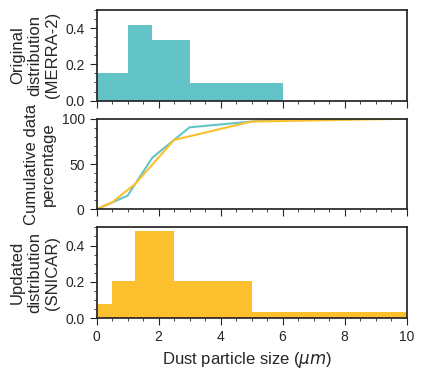

In [ ]:
y_snicar = [0.0751, 0.20535, 0.481675, 0.203775, 0.034]
y_merra = [0.150, 0.41944444444444456, 0.3354111111111112, 0.0952222222,0]
bins_snicar = [0,0.5,1.25,2.5,5,10]
bins_merra = [0,1,1.8,3,6,10]

percent_merra = np.append(np.array([0]), np.cumsum(y_merra) * 100)
percent_snicar = np.interp(bins_snicar, bins_merra, percent_merra)

fig, axes = plt.subplots(3,1,sharex=True, figsize=(4,4))

ax = axes[0]
width_merra = np.array(bins_merra[1:]) - np.array(bins_merra[:-1])
ax.bar(bins_merra[:-1], y_merra, align='edge', width=width_merra, color = gsplot.all_colors[0])
ax.set_ylabel('Original\ndistribution\n(MERRA-2)',fontsize=12)

ax = axes[1]
ax.plot(bins_merra, percent_merra, color=gsplot.all_colors[0])
ax.plot(bins_snicar, percent_snicar, color=gsplot.all_colors[1])
ax.set_ylabel('Cumulative data\npercentage',fontsize=12)

ax = axes[2]
width_snicar = np.array(bins_snicar[1:]) - np.array(bins_snicar[:-1])
ax.bar(bins_snicar[:-1], y_snicar, align='edge', width=width_snicar, color = gsplot.all_colors[1])
ax.set_xlim(0,10)
ax.set_ylabel('Updated\ndistribution\n(SNICAR)',fontsize=12)

for a,ax in enumerate(axes):
    ax.tick_params(length=5,labelsize=10)
    if a != 1:
        ax.set_ylim(0,0.5)
    else:
        ax.set_ylim(0,100)

    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    ax.minorticks_on()
    ax.tick_params(which='minor', length=2)
fig.supxlabel('Dust particle size ($\mu m$)',y=-0.02)
plt.savefig('/trace/group/rounce/cvwilson/Output/dust_fig.png',dpi=300, bbox_inches='tight')
plt.show()